In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.init as init
from torch.distributions import Categorical
from torch.nn import functional as F
import numpy as np
from tqdm import tqdm
import pandas as pd

from model.CustomDataSet import CustomDataSetRNN
from model.Tokenizer import SimpleTokenizerV1
from environnement.environnement1Str import Environnement1
from environnement.environnement3Str import Environnement3
from environnement.environnement6Str import Environnement6
from environnement.small_loop import small_loop
from environnement.gridWorld import gridWorld
from model.RNN import LSTM_GenText

from outil import *

In [2]:
# Create data
env_test = gridWorld(x= 1, y=1, theta=0, world= np.array([
                [1, 1, 1, 1, 1, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 0, 0, 0, 0, 1],
                [1, 1, 1, 1, 1, 1],
            ]))
actions, outcomes = [], []

inter_test = []
for i in range(10000):
    action = str(np.random.choice(env_test.get_actions()))
    outcome = env_test.outcome(action)
    actions.append(action)
    outcomes.append(outcome)
    inter_test.append((action, outcome))
    
for i in inter_test:
    print(i)

The robot is in : 0  x: 1 y: 1
World : [[1 1 1 1 1 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 0 0 0 0 1]
 [1 1 1 1 1 1]]
('turn_right', 'empty')
('forward', 'empty')
('feel_right', 'empty')
('feel_right', 'empty')
('turn_left', 'empty')
('forward', 'wall')
('turn_left', 'empty')
('feel_right', 'wall')
('turn_right', 'empty')
('feel_left', 'empty')
('feel_left', 'empty')
('feel_front', 'wall')
('feel_front', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('forward', 'wall')
('feel_right', 'empty')
('forward', 'wall')
('feel_right', 'empty')
('turn_left', 'empty')
('forward', 'empty')
('turn_left', 'empty')
('feel_left', 'empty')
('feel_right', 'empty')
('feel_left', 'empty')
('turn_right', 'empty')
('turn_right', 'empty')
('feel_right', 'empty')
('feel_front', 'wall')
('forward', 'wall')
('feel_left', 'empty')
('feel_front', 'wall')
('turn_left', 'empty')
('turn_left', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('f

In [3]:
# Create vocab
list_vocab = ['<pad>', '<sos>', '<eos>', '<unk>']
for act in env_test.get_actions():
    for fb in env_test.get_outcomes():
        list_vocab.append((act, fb))
for element in list_vocab:
    print(element)
    
tmp = create_dico_numerate_word(list_vocab)
print(tmp)

tokenizer = SimpleTokenizerV1(vocab=
        create_dico_numerate_word(tmp))
print(tokenizer.encode(("forward", "empty")))

<pad>
<sos>
<eos>
<unk>
('forward', 'wall')
('forward', 'empty')
('turn_left', 'wall')
('turn_left', 'empty')
('turn_right', 'wall')
('turn_right', 'empty')
('feel_front', 'wall')
('feel_front', 'empty')
('feel_left', 'wall')
('feel_left', 'empty')
('feel_right', 'wall')
('feel_right', 'empty')
{'<pad>': 0, '<sos>': 1, '<eos>': 2, '<unk>': 3, ('forward', 'wall'): 4, ('forward', 'empty'): 5, ('turn_left', 'wall'): 6, ('turn_left', 'empty'): 7, ('turn_right', 'wall'): 8, ('turn_right', 'empty'): 9, ('feel_front', 'wall'): 10, ('feel_front', 'empty'): 11, ('feel_left', 'wall'): 12, ('feel_left', 'empty'): 13, ('feel_right', 'wall'): 14, ('feel_right', 'empty'): 15}
5


In [4]:
# Model
num_layers = 2
hidden_size = 128
temp = 1.0
lstm_generator = LSTM_GenText(
    num_emb=len(list_vocab),
    hidden_size=hidden_size,
    emb_size=hidden_size,
    num_layers=num_layers,
    dropout=0.1
)
input_tokens = [tokenizer.encode((actions[i], outcomes[i])) for i in range(len(actions))]
print("prompt :")
for i in input_tokens:
    print(tokenizer.decode(i))
input_tokens = torch.tensor(input_tokens).reshape(1, -1)
lstm_generator.eval()
log_tokens = []
# Disable gradient calculation
with torch.no_grad():    
    # Initialize hidden and memory states
    hidden = torch.zeros(num_layers, 1, hidden_size)
    memory = torch.zeros(num_layers, 1, hidden_size)
    
    # Generate text
    for i in range(100):
        # Forward pass through LSTM generator
        data_pred, hidden, memory = lstm_generator(input_tokens, hidden, memory)
        
        # Sample from the distribution of probabilities (with temperature)
        dist = Categorical(logits=data_pred[:, -1] / temp)
        input_tokens = dist.sample().reshape(1, 1)
        
        # Append generated token to log_tokens
        log_tokens.append(input_tokens.cpu())
        
        # Check for end-of-sentence token
        if input_tokens.item() == 2:
            break
        
print("output :")
for i in log_tokens:
    print(tokenizer.decode(i.item()))



prompt :
('turn_right', 'empty')
('forward', 'empty')
('feel_right', 'empty')
('feel_right', 'empty')
('turn_left', 'empty')
('forward', 'wall')
('turn_left', 'empty')
('feel_right', 'wall')
('turn_right', 'empty')
('feel_left', 'empty')
('feel_left', 'empty')
('feel_front', 'wall')
('feel_front', 'wall')
('turn_right', 'empty')
('feel_left', 'wall')
('forward', 'empty')
('turn_left', 'empty')
('forward', 'wall')
('feel_right', 'empty')
('forward', 'wall')
('feel_right', 'empty')
('turn_left', 'empty')
('forward', 'empty')
('turn_left', 'empty')
('feel_left', 'empty')
('feel_right', 'empty')
('feel_left', 'empty')
('turn_right', 'empty')
('turn_right', 'empty')
('feel_right', 'empty')
('feel_front', 'wall')
('forward', 'wall')
('feel_left', 'empty')
('feel_front', 'wall')
('turn_left', 'empty')
('turn_left', 'empty')
('turn_left', 'empty')
('turn_right', 'empty')
('feel_front', 'empty')
('feel_right', 'empty')
('feel_left', 'empty')
('turn_left', 'empty')
('forward', 'empty')
('turn_ri

output :
('turn_left', 'wall')
('turn_left', 'empty')
('feel_right', 'wall')
<unk>
('feel_left', 'empty')
('feel_right', 'wall')
('turn_right', 'empty')
<unk>
('feel_right', 'empty')
<unk>
<eos>


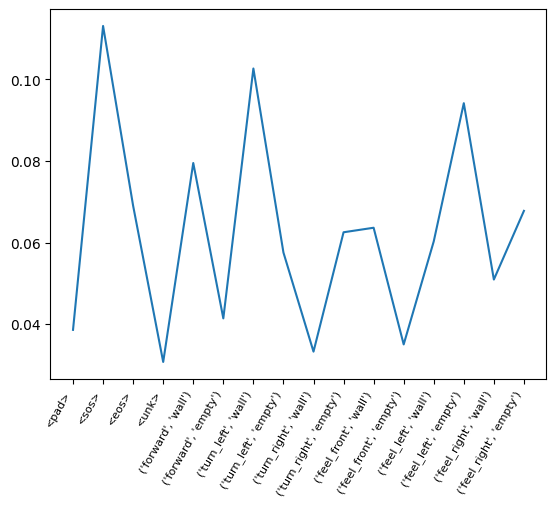

In [5]:
# Plot the distribution of probabilities
# write in absice the action and the feedback
plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(F.softmax(data_pred/temp, -1).cpu().numpy().flatten())

In [6]:
input_tokens = [tokenizer.encode(i) for i in inter_test]
print("prompt :")
for i in input_tokens:
    print(tokenizer.decode(i))
    print(i)

prompt :
('turn_right', 'empty')
9
('forward', 'empty')
5
('feel_right', 'empty')
15
('feel_right', 'empty')
15
('turn_left', 'empty')
7
('forward', 'wall')
4
('turn_left', 'empty')
7
('feel_right', 'wall')
14
('turn_right', 'empty')
9
('feel_left', 'empty')
13
('feel_left', 'empty')
13
('feel_front', 'wall')
10
('feel_front', 'wall')
10
('turn_right', 'empty')
9
('feel_left', 'wall')
12
('forward', 'empty')
5
('turn_left', 'empty')
7
('forward', 'wall')
4
('feel_right', 'empty')
15
('forward', 'wall')
4
('feel_right', 'empty')
15
('turn_left', 'empty')
7
('forward', 'empty')
5
('turn_left', 'empty')
7
('feel_left', 'empty')
13
('feel_right', 'empty')
15
('feel_left', 'empty')
13
('turn_right', 'empty')
9
('turn_right', 'empty')
9
('feel_right', 'empty')
15
('feel_front', 'wall')
10
('forward', 'wall')
4
('feel_left', 'empty')
13
('feel_front', 'wall')
10
('turn_left', 'empty')
7
('turn_left', 'empty')
7
('turn_left', 'empty')
7
('turn_right', 'empty')
9
('feel_front', 'empty')
11
('fe

{9: 1649, 5: 1069, 15: 1175, 7: 1690, 4: 604, 14: 457, 13: 1207, 10: 612, 12: 446, 11: 1091}
[0, 0, 0, 0, 604, 1069, 0, 1690, 0, 1649, 612, 1091, 446, 1207, 457, 1175]


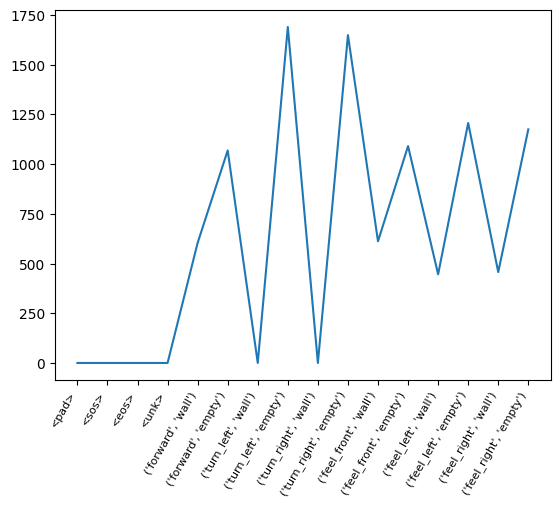

In [7]:
# Count each token
count = {}
for i in input_tokens:
    if i in count:
        count[i] += 1
    else:
        count[i] = 1
print(count)
values_count = []

for i in range(len(list_vocab)):
    if i in count:
        values_count.append(count[i])
    else:
        values_count.append(0)
print(values_count)

plt.xticks(range(len(list_vocab)), list_vocab, fontsize=8, rotation=60, ha='right')
plt.plot(values_count)

5
[[5], [15, 15, 7, 4, 7, 14, 9, 13, 13, 10, 10, 9, 12, 5], [7, 4, 15, 4, 15, 7, 5], [7, 13, 15, 13, 9, 9, 15, 10, 4, 13, 10, 7, 7, 7, 9, 11, 15, 13, 7, 5], [9, 9, 11, 5, 5], [13, 13, 4, 9, 7, 10, 14, 9, 15, 9, 11, 11, 7, 7, 7, 9, 9, 15, 10, 9, 15, 5], [15, 7, 10, 15, 13, 10, 10, 7, 7, 15, 11, 15, 13, 13, 5, 5], [9, 15, 13, 11, 13, 13, 9, 9, 9, 5], [4, 7, 7, 9, 5], [14, 9, 4, 4, 4, 4, 4, 9, 11, 7, 15, 15, 10, 15, 15, 9, 7, 4, 9, 12, 11, 11, 7, 9, 7, 15, 9, 7, 13, 10, 13, 7, 5], [4, 14, 7, 9, 10, 4, 4, 10, 13, 10, 14, 4, 14, 14, 14, 9, 9, 15, 7, 12, 12, 15, 15, 12, 9, 12, 12, 12, 5, 5], [15, 12, 12, 7, 15, 7, 7, 7, 12, 5], [4, 12, 4, 10, 9, 5], [9, 9, 13, 9, 4, 15, 4, 15, 15, 15, 4, 9, 12, 7, 15, 7, 7, 11, 15, 11, 11, 13, 15, 13, 15, 7, 12, 11, 12, 15, 12, 12, 5], [7, 4, 4, 9, 7, 10, 15, 4, 9, 9, 11, 15, 11, 7, 7, 7, 11, 7, 7, 7, 4, 15, 15, 9, 12, 9, 5], [15, 9, 15, 13, 7, 13, 15, 11, 11, 15, 13, 5, 5], [13, 7, 11, 11, 9, 9, 15, 9, 9, 13, 13, 9, 4, 7, 9, 10, 13, 13, 10, 9, 12, 15, 9, 9,

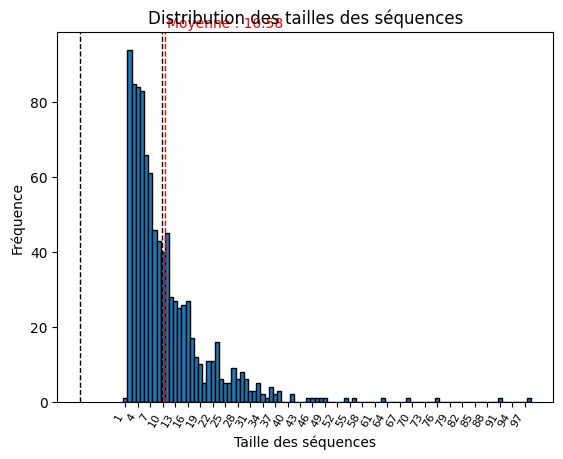

In [ ]:
# find all sequence between two token
def find_sequence(token, sequence):
    res = []
    sentence = []
    find_end = False
    for i in range(0, len(sequence) -1 ):
        if not(find_end) and sequence[i] == token:
            find_end = True
        if find_end :
            if sequence[i] == token and sequence[i +1] != token:
                res.append(sentence + [token])
                sentence = []
            else:
                sentence.append(sequence[i])
            
    return res

print(tokenizer.encode(("forward", "empty")))
sequences = find_sequence(tokenizer.encode(("forward", "empty")), input_tokens)
print(sequences)

# Stocker les tailles des séquences
sequence_lengths = [len(seq) for seq in sequences]

# Visualiser les tailles des séquences avec un histogramme
plt.hist(sequence_lengths, bins=range(min(sequence_lengths), max(sequence_lengths) + 2), align='left', edgecolor='black')
# Means of the sequence
plt.axvline(np.mean(sequence_lengths), color='red', linestyle='dashed', linewidth=1)
plt.axvline(np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)
plt.axvline(-np.std(sequence_lengths) + np.mean(sequence_lengths), color='black', linestyle='dashed', linewidth=1)

plt.text(np.mean(sequence_lengths) + 0.5, 100, 'Moyenne : {:.2f}'.format(np.mean(sequence_lengths)), color='red')
plt.xticks(range(min(sequence_lengths), max(sequence_lengths) + 1, 3), fontsize=8, rotation=60, ha='right')
plt.xlabel('Taille des séquences')
plt.ylabel('Fréquence')
plt.title('Distribution des tailles des séquences')
plt.show()

# Stocker les tailles des séquences et les séquence dans un pandas DataFrame
sequences_decode = [tokenizer.decode(seq) for seq in sequences]
df = pd.DataFrame({'taille': sequence_lengths, 'sequence': sequences_decode})
 



In [ ]:
# init data
print(inter_test)
data_set_test = CustomDataSetRNN(actions=actions, outcomes=outcomes,
                    context_lenght=15, dim_out=2, tokenizer=tokenizer)


[('feel_right', 'empty'), ('turn_left', 'empty'), ('turn_right', 'empty'), ('turn_left', 'empty'), ('feel_right', 'wall'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('turn_right', 'empty'), ('feel_right', 'empty'), ('feel_left', 'wall'), ('feel_front', 'empty'), ('turn_right', 'empty'), ('feel_left', 'empty'), ('feel_left', 'empty'), ('turn_right', 'empty'), ('turn_left', 'empty'), ('feel_right', 'wall'), ('feel_left', 'empty'), ('turn_left', 'empty'), ('forward', 'empty'), ('turn_right', 'empty'), ('feel_right', 'empty'), ('feel_left', 'empty'), ('feel_left', 'empty'), ('feel_left', 'empty'), ('feel_front', 'empty'), ('feel_front', 'empty'), ('forward', 'empty'), ('feel_left', 'empty'), ('feel_right', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('forward', 'empty'), ('feel_right', 'empty'), ('turn_right', 'empty'), ('feel_right', 'empty'), ('feel_right', 'empty'), ('forward', 'empty'), ('turn_left', 'empty'), ('feel_right', 'empty'), ('turn_left', 'empty'), ('tur

In [ ]:
# find pattern
find_sub_list()

TypeError: find_sub_list() missing 1 required positional argument: 'liste'

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)

print(input)
print(target)

tensor([[ 0.1907,  0.4952, -0.1845, -0.5411, -0.6093],
        [ 1.4464,  0.4050, -0.0440,  1.6137, -0.5413],
        [ 0.6848, -0.6933,  0.5430, -0.1197, -2.2319]], requires_grad=True)
tensor([1, 0, 1])




Inspired by https://github.com/LukeDitria/pytorch_tutorials.git

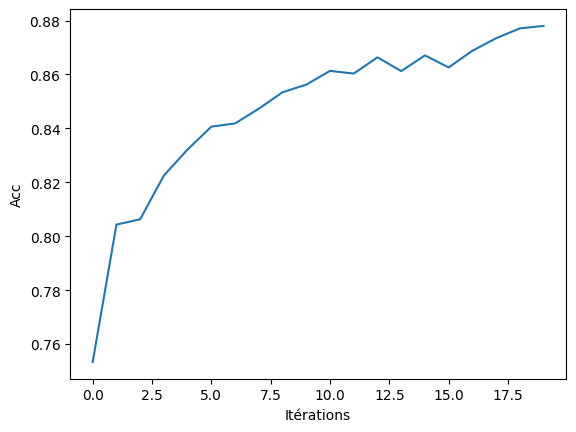

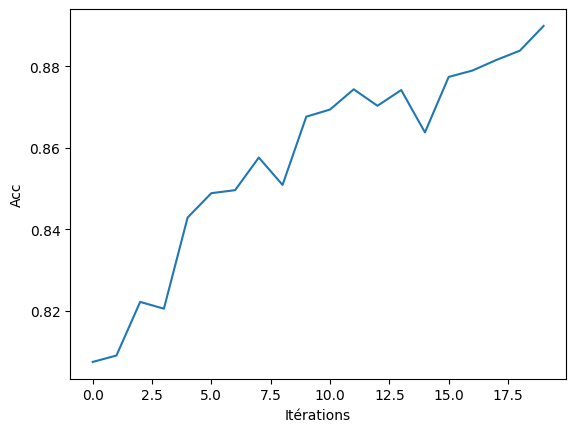

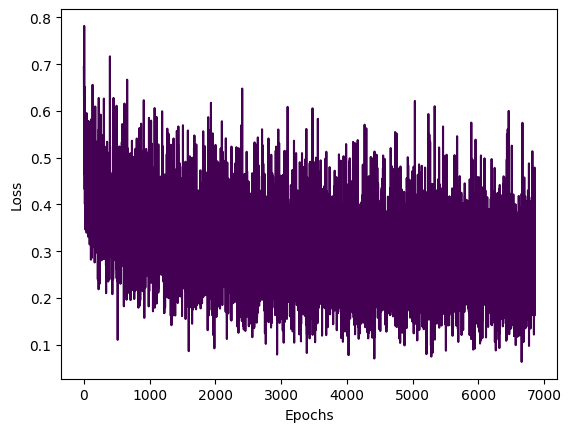

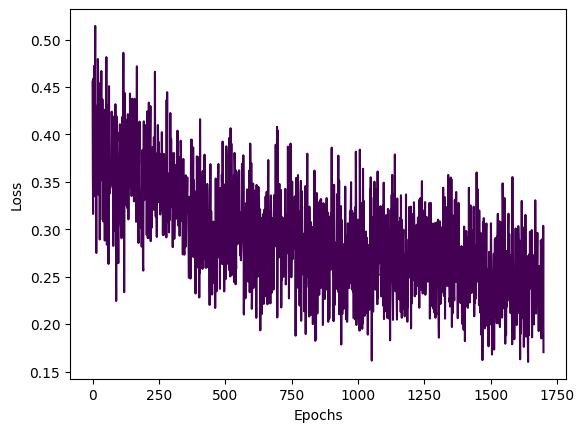

In [ ]:
see_evolued_acc(training_acc_logger)
see_evolued_acc(test_acc_logger)

see_evolued_loss([training_loss_logger])
see_evolued_loss([test_loss_logger])

In [ ]:
print(training_loss_logger)

[0.6938008666038513, 0.6913725733757019, 0.6618072986602783, 0.6280667781829834, 0.5401561856269836, 0.5672983527183533, 0.7818799614906311, 0.46570777893066406, 0.48325151205062866, 0.4753558039665222, 0.6517048478126526, 0.46616098284721375, 0.5139290690422058, 0.5567008256912231, 0.4324859380722046, 0.4837859570980072, 0.40065997838974, 0.48861509561538696, 0.4370916485786438, 0.570571780204773, 0.5253856182098389, 0.5485976934432983, 0.48010578751564026, 0.3466828763484955, 0.4798088073730469, 0.5523812174797058, 0.491582989692688, 0.38081037998199463, 0.46457603573799133, 0.5658149123191833, 0.5044046640396118, 0.35156041383743286, 0.42086949944496155, 0.4181661009788513, 0.519877552986145, 0.5227026343345642, 0.35072213411331177, 0.41907399892807007, 0.5537469983100891, 0.45971226692199707, 0.48977887630462646, 0.5956421494483948, 0.3395719528198242, 0.5639675855636597, 0.5037829875946045, 0.49259909987449646, 0.5176793336868286, 0.4530419707298279, 0.38338229060173035, 0.5183501